<a href="https://colab.research.google.com/github/helonayala/pinn/blob/main/01_DeepVIV_sec21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Physics-informed Artificial Neural Network for Friction Identification

Author: Helon Ayala, October 2020

# Quick description



# Problem definition

In summary, we will use the Physics-informed artificial neural networks (PINNs) for solving the forward and inverse problems related to the dynamics of a positioning system with friction

$$
\rho \ddot x (t) + f_f \left[ \dot x (t) \right] = \tau (t)
$$

where the terms are described as follows
* $\rho$: inertia;
* $x(t)$: displacement;
* $\tau(t)$: sum of external forces
* $f_f[\cdot]$: friction forces, energy dissipation term dependent on velocity

On one hand, the forward problem relates to solving numerically the 2nd order ODE described in the EOM given. On the other hand, the inverse problems related to inferring the parameters of the system

# Assumptions

We work under the assumptions that
* we know the time series $[x(t),f(t)]$, and
* we know the constitutive model of the system under study

# Imports and definitions 


In [1]:
#@title
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# progress bar for model.fit function
import tensorflow_addons as tfa
import tqdm
from IPython.display import clear_output

# set random seed for reproduction
tf.random.set_seed(42)

# initialize tqdm callback
tqdm_callback = tfa.callbacks.TQDMProgressBar(
  leave_epoch_progress = True,
  leave_overall_progress = True,
  show_epoch_progress = False,
  show_overall_progress = True,
  )


Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: tensorflow-addons in /home/helon/.local/lib/python3.8/site-packages (0.11.2)


# Load data and plot

Sampling time (mean +- std): 0.001000 +- 0.000000
There are 24841 samples


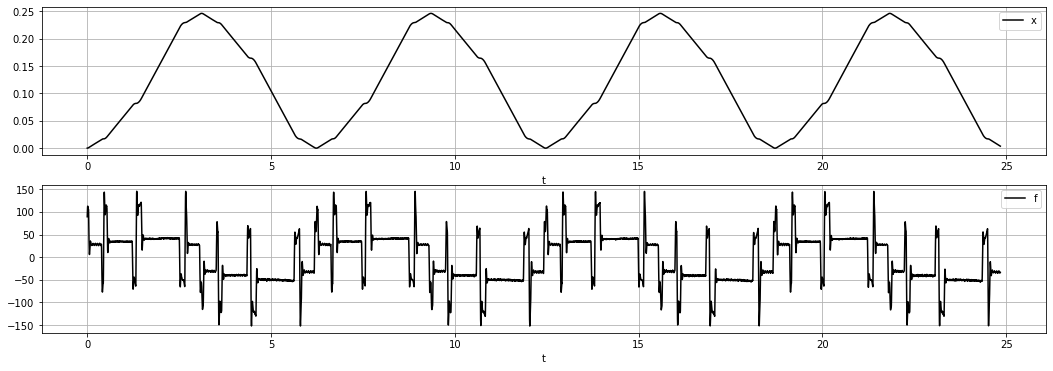

In [2]:
EMPS = loadmat(os.path.join("data", "DATA_EMPS.mat"))

x,f,t = (EMPS['qm'].astype(np.float32), EMPS['gtau'].ravel() * EMPS['vir'].astype(np.float32), EMPS['t'].astype(np.float32))

print('Sampling time (mean +- std): %f +- %f' % (np.mean(np.diff(t.ravel())), np.std(np.mean(np.diff(t.ravel())))))

N_train = t.shape[0] # how much data ?

print('There are %d samples' % N_train)

# time series plots 
plt.figure(figsize=[18,6])
plt.subplot(211)
plt.plot(t,x,'k')
plt.legend('x'), plt.xlabel('t'), plt.grid()

plt.subplot(212)
plt.plot(t,f,'k')
plt.legend('f'), plt.xlabel('t'), plt.grid()
plt.show()

# Definition of the custom classes from tf.keras



In [3]:
# layer class
class tToXandF(tf.keras.layers.Layer):
    """
    Here we define the layers for the PINNs usign tf.keras and subclassing.

    Although semantically I think it would be clearer to use 2 layers objects (1 for the $\hat x = f(t) $ and 1 for the ODE/inverse problem), I had to use one layer for both PINN blocks. 

    I could not make it work with 2 different layers, probably because of the inner functioning of the tf.GradientTape function (to be investigated ...).
    """
    def __init__(self, layerWidth, actFcn, timevec, name="tToX", **kwargs):
        super(tToXandF, self).__init__(name=name, **kwargs)

        # rescale data
        self.minX = np.min(timevec)
        self.maxX = np.max(timevec)

        # instantiates hidden layers recursively
        self.denseList = []
        for nNeurons in layerWidth:
            self.denseList.append(
                tf.keras.layers.Dense(nNeurons, activation=actFcn)
            )  # hidden layers

        self.denseList.append(tf.keras.layers.Dense(1))  # output layer

        self.M = tf.Variable(100, name="k", trainable=True, dtype=tf.float32)
        self.Fv = tf.Variable(250, name="b", trainable=True, dtype=tf.float32)

    def call(self, t):

        with tf.GradientTape(
            persistent=True  # persistent for 2nd order derivative
        ) as tape:

            tape.watch(t)
            # part 1: calculate  t->x
            x = 1-2*(self.maxX - t) / (self.maxX - self.minX) # rescale [-1,1]
            for nLayers in range(self.denseList.__len__()):
                x = self.denseList[nLayers](x)

            # part 2a: calculate the gradients of x wrt t
            xp = tape.gradient(x, t)
            xpp = tape.gradient(xp, t)

            # part 2b: calculate the EOM
            f = self.M * xpp + self.Fv * xp

        return x, f

# layer class
class tToX(tf.keras.layers.Layer):
    """
    This is a preliminary layer t -> x
    we will try to see if it is possible to model this 1st part.
    """
    def __init__(self, layerWidth, actFcn, timevec, name="tToX", **kwargs):
        super(tToX, self).__init__(name=name, **kwargs)

        # rescale data
        self.minX = np.min(timevec)
        self.maxX = np.max(timevec)

        # instantiates hidden layers recursively
        self.denseList = []
        for nNeurons in layerWidth:
            self.denseList.append(
                tf.keras.layers.Dense(nNeurons, activation=actFcn)
            )  # hidden layers

        self.denseList.append(tf.keras.layers.Dense(1))  # output layer

    def call(self, t):
        x = 1-2*(self.maxX - t) / (self.maxX - self.minX) # rescale [-1,1]
        for nLayers in range(self.denseList.__len__()):
            x = self.denseList[nLayers](x)
        return x

# model class
class PINN(tf.keras.Model):
    def __init__(self,timevec, layerWidth=10 * [32], actFcn=tf.cos, name="PINN", **kwargs):
        super(PINN, self).__init__(name=name, **kwargs)

        self.tToXandF = tToXandF(layerWidth=layerWidth, actFcn=actFcn, timevec= timevec)

    def call(self, t):
        return self.tToXandF(t)

# model class
class subPINN(tf.keras.Model):
    def __init__(self,timevec, layerWidth=10 * [32], actFcn=tf.sin, name="subPINN", **kwargs):
        super(subPINN, self).__init__(name=name, **kwargs)

        self.tToX = tToX(layerWidth=layerWidth, actFcn=actFcn, timevec= timevec)

    def call(self, t):
        return self.tToX(t)

# Callbacks for watching variables
class VariableValue(tf.keras.callbacks.Callback):
    def __init__(self, vars_to_track):
        super(VariableValue, self).__init__()
        self.vars_to_track = vars_to_track
        self.valueList = [] # list with all variables tracked (each epoch is an element)
    def on_epoch_begin(self, epoch, logs):
        tftensor2np = [x.numpy() for x in self.vars_to_track] # convert tf.tensor to list of numpy
        self.valueList.append(tftensor2np) # append for tracking

# Callbacks for plotting outputs
class PlotOutput(tf.keras.callbacks.Callback):
    def __init__(self,x,y,atEveryEpoch = 10):
        super(PlotOutput, self).__init__()
        self.x = x
        self.y = y
        self.atEveryEpoch = atEveryEpoch
    def on_epoch_begin(self, epoch, logs):
        # plot measured vs. predicted outputs

        if not (epoch % self.atEveryEpoch):
            yh1, yh2 = self.model.predict(self.x)

            clear_output(wait=True)

            plt.figure(figsize=[14,5])
            plt.subplot(121)
            plt.plot(self.x, self.y[0], 'k-',linewidth = 3, label="true")
            plt.plot(self.x, yh1,'ro', label="predicted")   
            plt.legend(), plt.title(epoch)
            
            plt.subplot(122)
            plt.plot(self.x, self.y[1], 'k-',linewidth = 3, label="true")
            plt.plot(self.x, yh2,'ro', label="predicted")
            plt.legend(), plt.title(epoch)
            plt.show()



# Callbacks for plotting outputs
class PlotOutput2(tf.keras.callbacks.Callback):
    def __init__(self,x,y,atEveryEpoch = 10):
        super(PlotOutput2, self).__init__()
        self.x = x
        self.y = y
        self.atEveryEpoch = atEveryEpoch
    def on_epoch_begin(self, epoch, logs):
        # plot measured vs. predicted outputs

        if not (epoch % self.atEveryEpoch):
            yh1 = self.model.predict(self.x)

            clear_output(wait=True)

            plt.figure(figsize=[7,5])      
            plt.plot(self.x, self.y, 'k-',linewidth = 3, label="true")
            plt.plot(self.x, yh1,'ro', label="predicted")   
            plt.legend(), plt.title(epoch)
            plt.show()

# Instantiate PINN model and define hyperparameters

In [4]:
# default parameters are the same as DeepVIV paper
# mdl = PINN(timevec = t)  

mdl = subPINN(timevec = t,layerWidth=1 * [10], actFcn  ='sigmoid')  

# learning rate and number of epochs
lrvec = np.array([1e-2, 1e-3, 1e-4, 1e-5])
epvec = np.array([2e3, 3e3, 3e3, 2e3], dtype="int32")

# callback - variables to watch
# varList = [mdl.tToXandF.M, mdl.tToXandF.Fv]


# Train model

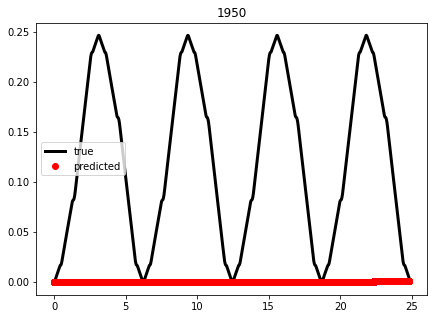

Model: "subPINN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tToX (tToX)                  multiple                  31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [5]:
nTrain = lrvec.shape[0]
history = []
clbkVarValue = []
# pltCalback = PlotOutput(x=t, y=[x,f],atEveryEpoch = 50)
pltCalback = PlotOutput2(x=t, y=x,atEveryEpoch = 50)
for i in range(nTrain):
    print("Learning rate:", lrvec[i])

    # clbkVarValue.append(VariableValue(varList)) # instantiate callback (for saving identified values)

    # mdl.compile(tf.keras.optimizers.Adam(learning_rate=lrvec[i]), loss="mse",metrics=tf.keras.metrics.MeanAbsolutePercentageError())
    mdl.compile(tf.keras.optimizers.Adam(learning_rate=lrvec[i]), loss = tf.keras.losses.MAPE, metrics=tf.keras.metrics.MeanAbsolutePercentageError())

    history.append(
        mdl.fit(
            x=t,
            # y=[x, f],
            y=x,
            epochs=epvec[i],
            batch_size=N_train,
            # verbose=0,
            # callbacks=[tqdm_callback, clbkVarValue[i]],
            # verbose=0,
            # callbacks=[pltCalback,clbkVarValue[i]],
            verbose=0,
            callbacks=[pltCalback],
            )
        )

mdl.summary()


# Plot training convergence

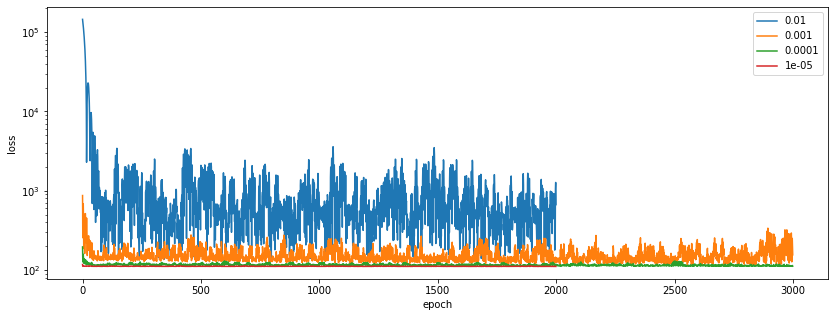

In [6]:
plt.figure(figsize=[14,5])
for i in range(nTrain):
    plt.plot(history[i].history['loss'])
plt.semilogy(), plt.legend(lrvec), plt.ylabel('loss'), plt.xlabel('epoch')
plt.show()


In [7]:
xh, fh = mdl.predict(t)

plt.figure(figsize=[14, 10])
plt.subplot(221)
plt.plot(t, x, "b-", t, xh, "ro")
plt.legend(["y", "xh"])
plt.subplot(223)
plt.plot(x,xh, "ro")
xmin, ymax = (np.min([x.min(),xh.min()]),np.max([x.max(),xh.max()]))
plt.plot(np.array([xmin,ymax]),np.array([xmin,ymax]), color = 'black', linewidth = 2) # this is just a 45º line
plt.xlabel('x'), plt.ylabel('xh')

plt.subplot(222)
plt.plot(t, f, "b-", t, fh, "ro")
plt.legend(["f", "fh"])
plt.subplot(224)
plt.plot(f,fh, "ro")
xmin, ymax = (np.min([f.min(),fh.min()]),np.max([f.max(),fh.max()]))
plt.plot(np.array([xmin,ymax]),np.array([xmin,ymax]), color = 'black', linewidth = 2) # this is just a 45º line
plt.xlabel('f'), plt.ylabel('fh')

plt.show()


ValueError: too many values to unpack (expected 2)

# Parameter identification analysis

In [ ]:
plt.figure(figsize=[14, 5])
plt.subplot(121)
epoch = 0
for i in range(nTrain):
    hatMatrix = np.array(clbkVarValue[i].valueList)
    plt.plot(hatMatrix[:,0:1])
plt.xlabel('epoch'), plt.legend(lrvec), plt.title('b')

plt.subplot(122)
for i in range(nTrain):
    hatMatrix = np.array(clbkVarValue[i].valueList)
    plt.plot(hatMatrix[:,1:])
plt.xlabel('epoch'), plt.legend(leg), plt.title('k')
plt.show()



# TODO

2-stage procedure
* train 1st block
* reloading into full PINN model, trainable = False
* train 2nd block